In [57]:
import pandas as pd
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
from tqdm import tqdm
import time
from label_map import id2label  # Label 정보 매핑용 사전, label.py의 내용을 불러 옴
import matplotlib.pyplot as plt

In [58]:
df = pd.read_csv('../../db/news_2023_2025.csv', encoding='utf-8')
df.head(1)

,news_id,wdate,title,article,press,url,image
0,20250523_0001,2025-05-23 19:11,[마켓인]모태펀드 존속 불확실성 해소될까…이재명 공약에 업계 주목,"2035년 종료 앞둬, 존속 공약에 기대감\n창업 초기자금 공백 완화 가능성에 업계...",이데일리,https://n.news.naver.com/mnews/article/018/000...,https://imgnews.pstatic.net/image/018/2025/05/...


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58405 entries, 0 to 58404
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   news_id  58405 non-null  object
 1   wdate    58405 non-null  object
 2   title    58405 non-null  object
 3   article  58405 non-null  object
 4   press    58405 non-null  object
 5   url      58405 non-null  object
 6   image    58405 non-null  object
dtypes: object(7)
memory usage: 3.1+ MB


In [60]:
# NER 모델 및 토크나이저 불러오기
model_name = "KPF/KPF-BERT-NER"
ner_pipeline = pipeline(
    task="ner",
    model=model_name,
    tokenizer=model_name,
    aggregation_strategy="simple",
    framework="pt",
)

Device set to use cpu


In [ ]:
# 종목명 사전 불러오기
company_df = pd.read_csv("../../db/KRX_KOSPI.csv", encoding="cp949")
company_names = set(company_df["종목명"].dropna().unique())

In [62]:
company_df[company_df["종목명"] == "스틱인베스트먼트"]

,종목코드,종목명,종가,대비,등락률,상장시가총액
358,26890,스틱인베스트먼트,10760,220,2.09,448457.0


In [63]:
# 뉴스 데이터 불러오기 및 제목 + 본문 결합
df["text_combined"] = (
    (df["title"].fillna("") + " " + df["article"].fillna(""))
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

In [64]:
df.head(1)

,news_id,wdate,title,article,press,url,image,text_combined
0,20250523_0001,2025-05-23 19:11,[마켓인]모태펀드 존속 불확실성 해소될까…이재명 공약에 업계 주목,"2035년 종료 앞둬, 존속 공약에 기대감\n창업 초기자금 공백 완화 가능성에 업계...",이데일리,https://n.news.naver.com/mnews/article/018/000...,https://imgnews.pstatic.net/image/018/2025/05/...,[마켓인]모태펀드 존속 불확실성 해소될까…이재명 공약에 업계 주목 2035년 종료 ...


In [65]:
# 텍스트 자르기
def split_text(text, max_length=500):
    return [text[i : i + max_length] for i in range(0, len(text), max_length)]

In [66]:
# WordPiece 병합 + 라벨 기반 종목 추출
def extract_stock_labels_by_label_id(text):
    chunks = split_text(text, max_length=500)
    matched_names = set()

    for chunk in chunks:
        entities = ner_pipeline(chunk)

        # WordPiece 병합 처리
        merged_entities = []
        current_word = ""
        current_score = []
        current_label = ""
        for ent in entities:
            word = ent["word"]
            score = ent["score"]
            label_id = ent["entity_group"]
            label_num = int(label_id.split("_")[1])
            label_name = id2label.get(label_num, "")
            key = label_name[2:] if label_name.startswith(("B-", "I-")) else label_name

            # 경제 조직 라벨로 제한 (OGG_ECONOMY 포함)
            if key.startswith("OGG_ECONOMY"):
                if word.startswith("##"):
                    current_word += word[2:]
                    current_score.append(score)
                else:
                    if current_word:
                        merged_entities.append(
                            (
                                current_word,
                                current_label,
                                sum(current_score) / len(current_score),
                            )
                        )
                    current_word = word
                    current_score = [score]
                    current_label = label_name
        if current_word:
            merged_entities.append(
                (current_word, current_label, sum(current_score) / len(current_score))
            )

        for word, label, score in merged_entities:
            if word in company_names:
                matched_names.add(word)

    return list(matched_names)

In [67]:
# 전체 뉴스에 NER 적용

results = []
start_time = time.time()

progress = tqdm(
    enumerate(df["text_combined"]),
    total=len(df),
    desc="전체 뉴스 종목명 라벨링 중",
)

for idx, text in progress:
    try:
        matched = extract_stock_labels_by_label_id(text)
    except Exception as e:
        print(f"오류 (인덱스 {idx}): {e}")
        matched = []
    results.append(matched)

    # 평균 시간 및 남은 시간 계산
    elapsed = time.time() - start_time
    avg_time = elapsed / (idx + 1)
    remaining = avg_time * (len(df) - idx - 1)

    # 진행률 바에 부가 정보 추가
    progress.set_postfix(
        {
            "진행": f"{idx+1}/{len(df)}",
            "평균": f"{avg_time:.2f}s",
            "남은시간": f"{remaining:.1f}s",
        }
    )

df["labels_by_id"] = results

전체 뉴스 종목명 라벨링 중: 100%|██████████| 58405/58405 [5:41:03<00:00,  2.85it/s, 진행=58405/58405, 평균=0.35s, 남은시간=0.0s]       


In [82]:
df.to_csv("news_2023_2025_with_NER.csv", index=False)

In [69]:
df.head(3)

,news_id,wdate,title,article,press,url,image,text_combined,labels_by_id
0,20250523_0001,2025-05-23 19:11,[마켓인]모태펀드 존속 불확실성 해소될까…이재명 공약에 업계 주목,"2035년 종료 앞둬, 존속 공약에 기대감\n창업 초기자금 공백 완화 가능성에 업계...",이데일리,https://n.news.naver.com/mnews/article/018/000...,https://imgnews.pstatic.net/image/018/2025/05/...,[마켓인]모태펀드 존속 불확실성 해소될까…이재명 공약에 업계 주목 2035년 종료 ...,[]
1,20250523_0002,2025-05-23 18:52,"[단독] 카카오페이, 2500만 회원 쓱·스마일페이 품나…간편결제 시장 빅3 경쟁 후끈",매각가 5000억 안팎 달할듯\n결제시장 내 입지강화 포석\n카카오페이 [사진 = ...,매일경제,https://n.news.naver.com/mnews/article/009/000...,https://imgnews.pstatic.net/image/009/2025/05/...,"[단독] 카카오페이, 2500만 회원 쓱·스마일페이 품나…간편결제 시장 빅3 경쟁 ...",[카카오페이]
2,20250523_0003,2025-05-23 18:38,"키스트론, 일반 청약 흥행…증거금 6조원 모았다","5월22~23일 청약 진행, 경쟁률 총2166대1\n상장 후 예상 시가총개 643억...",머니투데이,https://n.news.naver.com/mnews/article/008/000...,https://imgnews.pstatic.net/image/008/2025/05/...,"키스트론, 일반 청약 흥행…증거금 6조원 모았다 5월22~23일 청약 진행, 경쟁률...",[]


In [70]:
df_filtered = df[df["labels_by_id"].apply(lambda x: len(x) > 0)]

In [71]:
# 2. label_by_id[0] 값을 stock_name으로 저장
df_filtered["stock_name"] = df_filtered["labels_by_id"].apply(lambda x: x[0] if len(x) > 0 else None)

# 3. company_df를 기준으로 stock_name → stock_id 매핑
df_filtered = df_filtered.merge(company_df, how="left", left_on="stock_name", right_on="종목명")
df_filtered = df_filtered.rename(columns={"id": "stock_id"})

# 4. 종목명 컬럼은 필요 시 제거
df_filtered.drop(columns=["종목명", "종가", "대비", "등락률"], inplace=True)

C:\Users\user\AppData\Local\Temp\ipykernel_18620\2462263517.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["stock_name"] = df_filtered["labels_by_id"].apply(lambda x: x[0] if len(x) > 0 else None)


In [72]:
df_filtered.head(3)

,news_id,wdate,title,article,press,url,image,text_combined,labels_by_id,stock_name,종목코드,상장시가총액
0,20250523_0002,2025-05-23 18:52,"[단독] 카카오페이, 2500만 회원 쓱·스마일페이 품나…간편결제 시장 빅3 경쟁 후끈",매각가 5000억 안팎 달할듯\n결제시장 내 입지강화 포석\n카카오페이 [사진 = ...,매일경제,https://n.news.naver.com/mnews/article/009/000...,https://imgnews.pstatic.net/image/009/2025/05/...,"[단독] 카카오페이, 2500만 회원 쓱·스마일페이 품나…간편결제 시장 빅3 경쟁 ...",[카카오페이],카카오페이,377300,5239577.0
1,20250523_0004,2025-05-23 18:33,"골드만삭스 차기 CEO, 이재용·김병주·이창용 만났다",[사진=연합뉴스]\n세계 2위 투자은행(IB)인 골드만삭스의 사장 겸 최고운영책임자...,매일경제,https://n.news.naver.com/mnews/article/009/000...,https://imgnews.pstatic.net/image/009/2025/05/...,"골드만삭스 차기 CEO, 이재용·김병주·이창용 만났다 [사진=연합뉴스] 세계 2위 ...",[삼성전자],삼성전자,5930,329723832.0
2,20250523_0005,2025-05-23 18:24,흔들리는 미국…달러 패권 붕괴에 '스테이블코인' 선택한 美,/사진=게티이미지뱅크\n미국 정부가 달러의 기축통화 지위를 위협하는 금에 대응하기 ...,머니투데이,https://n.news.naver.com/mnews/article/008/000...,https://imgnews.pstatic.net/image/008/2025/05/...,흔들리는 미국…달러 패권 붕괴에 '스테이블코인' 선택한 美 /사진=게티이미지뱅크 미...,[상상인증권],상상인증권,1290,62294.0


In [73]:
df_filtered["종목코드"] = df_filtered["종목코드"].astype(str).str.zfill(6)

In [74]:
df_filtered.head(3)

,news_id,wdate,title,article,press,url,image,text_combined,labels_by_id,stock_name,종목코드,상장시가총액
0,20250523_0002,2025-05-23 18:52,"[단독] 카카오페이, 2500만 회원 쓱·스마일페이 품나…간편결제 시장 빅3 경쟁 후끈",매각가 5000억 안팎 달할듯\n결제시장 내 입지강화 포석\n카카오페이 [사진 = ...,매일경제,https://n.news.naver.com/mnews/article/009/000...,https://imgnews.pstatic.net/image/009/2025/05/...,"[단독] 카카오페이, 2500만 회원 쓱·스마일페이 품나…간편결제 시장 빅3 경쟁 ...",[카카오페이],카카오페이,377300,5239577.0
1,20250523_0004,2025-05-23 18:33,"골드만삭스 차기 CEO, 이재용·김병주·이창용 만났다",[사진=연합뉴스]\n세계 2위 투자은행(IB)인 골드만삭스의 사장 겸 최고운영책임자...,매일경제,https://n.news.naver.com/mnews/article/009/000...,https://imgnews.pstatic.net/image/009/2025/05/...,"골드만삭스 차기 CEO, 이재용·김병주·이창용 만났다 [사진=연합뉴스] 세계 2위 ...",[삼성전자],삼성전자,005930,329723832.0
2,20250523_0005,2025-05-23 18:24,흔들리는 미국…달러 패권 붕괴에 '스테이블코인' 선택한 美,/사진=게티이미지뱅크\n미국 정부가 달러의 기축통화 지위를 위협하는 금에 대응하기 ...,머니투데이,https://n.news.naver.com/mnews/article/008/000...,https://imgnews.pstatic.net/image/008/2025/05/...,흔들리는 미국…달러 패권 붕괴에 '스테이블코인' 선택한 美 /사진=게티이미지뱅크 미...,[상상인증권],상상인증권,001290,62294.0


In [75]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pykrx.stock import get_market_ohlcv_by_date

# ✅ 등락률 구간 설정
delta_days = [-30, -14, -7, -3, -2, -1, 0, 1, 2, 3, 7, 14, 30]


def get_price_and_returns(code: str, base_date: pd.Timestamp):
    """
    주어진 종목코드(code)와 기준일(base_date)을 기준으로
    기준일 종가와 D±N일 등락률 반환
    """
    start = (base_date + timedelta(days=min(delta_days) - 5)).strftime("%Y%m%d")
    end = (base_date + timedelta(days=max(delta_days) + 5)).strftime("%Y%m%d")

    try:
        df_price = get_market_ohlcv_by_date(start, end, code)
    except:
        return None  # 종목코드 오류 시

    df_price.index = pd.to_datetime(df_price.index)

    # base_price 찾기
    try:
        base_actual = df_price.index[
            df_price.index.get_indexer([base_date], method="nearest")[0]
        ]
        base_price = df_price.loc[base_actual, "종가"]
    except:
        return None

    result = {"base_price": int(base_price)}

    for d in delta_days:
        if d == 0:
            continue
        target = base_date + timedelta(days=d)
        try:
            actual_target = df_price.index[
                df_price.index.get_indexer([target], method="nearest")[0]
            ]
            target_price = df_price.loc[actual_target, "종가"]
            rate = round(((target_price - base_price) / base_price) * 100, 2)
            result[f"D{d:+d}"] = rate
        except:
            result[f"D{d:+d}"] = np.nan  # 값 없음 처리

    return result

In [76]:
# 날짜 형식 변환
df_filtered["wdate"] = pd.to_datetime(df_filtered["wdate"])

# 결과 저장용
price_data = []

for _, row in tqdm(df_filtered.iterrows(), total=len(df_filtered), desc="뉴스별 주가 조회 진행 중"):
    result = get_price_and_returns(row["종목코드"], row["wdate"])
    price_data.append(result if result else {})  # None → 빈 dict

# 컬럼 확장
price_df = pd.DataFrame(price_data)
df_combined = pd.concat([df_filtered, price_df], axis=1)

뉴스별 주가 조회 진행 중: 100%|██████████| 35238/35238 [18:06<00:00, 32.45it/s]


In [77]:
df_combined.head(3)

,news_id,wdate,title,article,press,url,image,text_combined,labels_by_id,stock_name,...,D-7,D-3,D-2,D-1,D+1,D+2,D+3,D+7,D+14,D+30
0,20250523_0002,2025-05-23 18:52:00,"[단독] 카카오페이, 2500만 회원 쓱·스마일페이 품나…간편결제 시장 빅3 경쟁 후끈",매각가 5000억 안팎 달할듯\n결제시장 내 입지강화 포석\n카카오페이 [사진 = ...,매일경제,https://n.news.naver.com/mnews/article/009/000...,https://imgnews.pstatic.net/image/009/2025/05/...,"[단독] 카카오페이, 2500만 회원 쓱·스마일페이 품나…간편결제 시장 빅3 경쟁 ...",[카카오페이],카카오페이,...,-4.06,-3.57,-1.62,0.0,4.22,4.22,16.72,26.30,26.30,26.30
1,20250523_0004,2025-05-23 18:33:00,"골드만삭스 차기 CEO, 이재용·김병주·이창용 만났다",[사진=연합뉴스]\n세계 2위 투자은행(IB)인 골드만삭스의 사장 겸 최고운영책임자...,매일경제,https://n.news.naver.com/mnews/article/009/000...,https://imgnews.pstatic.net/image/009/2025/05/...,"골드만삭스 차기 CEO, 이재용·김병주·이창용 만났다 [사진=연합뉴스] 세계 2위 ...",[삼성전자],삼성전자,...,4.80,2.77,0.92,0.0,0.92,0.92,-0.55,3.14,3.14,3.14
2,20250523_0005,2025-05-23 18:24:00,흔들리는 미국…달러 패권 붕괴에 '스테이블코인' 선택한 美,/사진=게티이미지뱅크\n미국 정부가 달러의 기축통화 지위를 위협하는 금에 대응하기 ...,머니투데이,https://n.news.naver.com/mnews/article/008/000...,https://imgnews.pstatic.net/image/008/2025/05/...,흔들리는 미국…달러 패권 붕괴에 '스테이블코인' 선택한 美 /사진=게티이미지뱅크 미...,[상상인증권],상상인증권,...,4.33,2.47,-2.47,0.0,-1.24,-1.24,-4.12,8.66,8.66,8.66


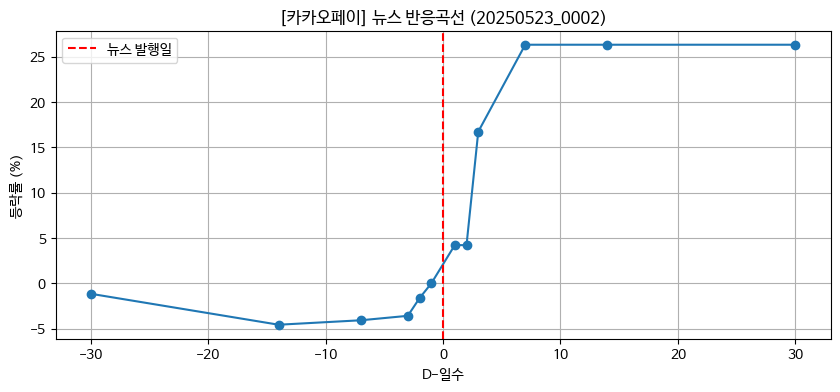

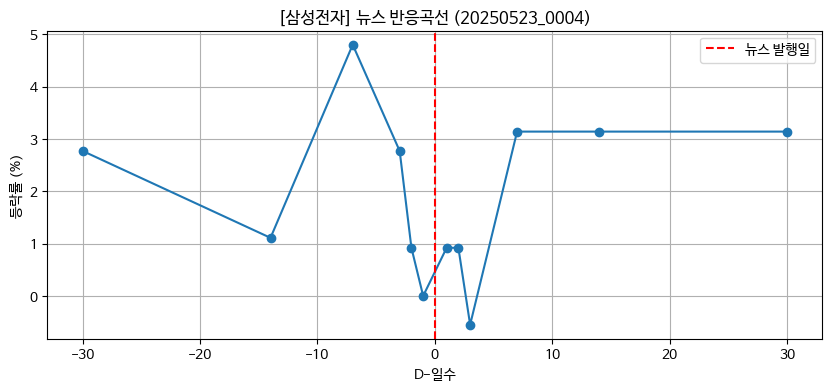

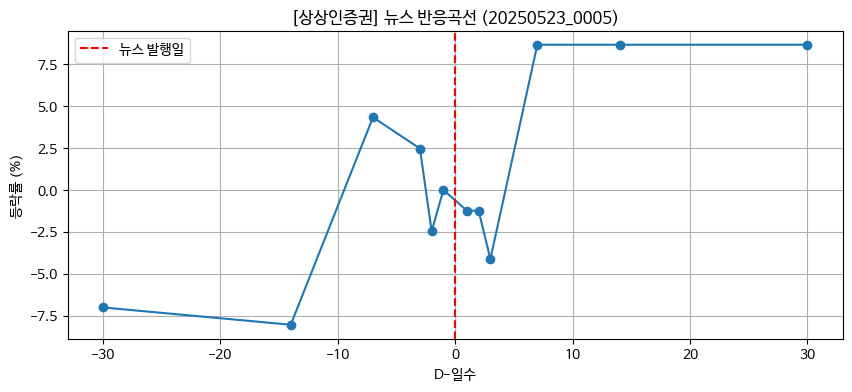

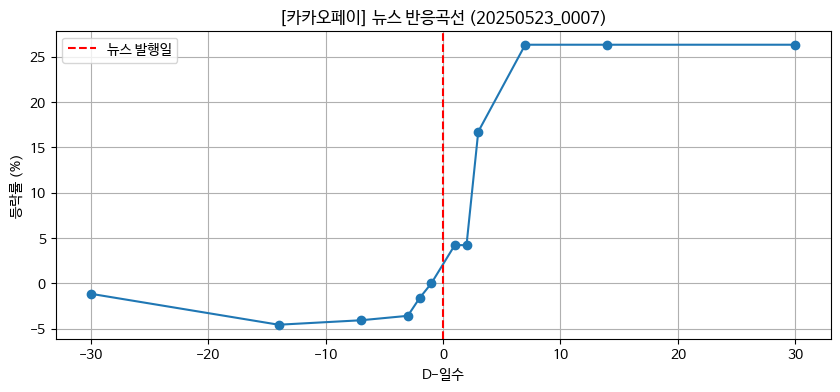

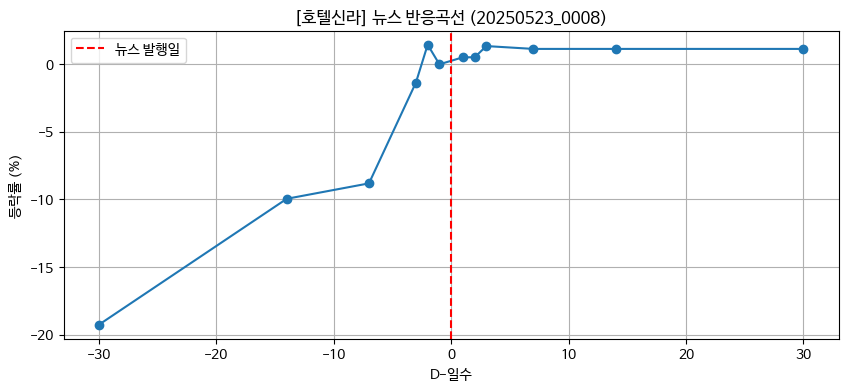

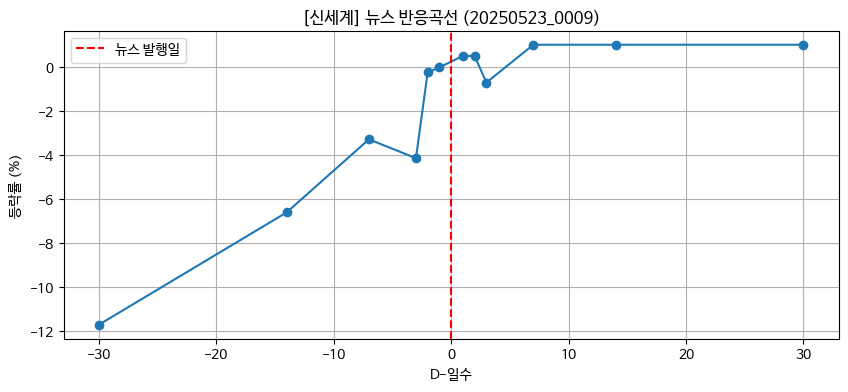

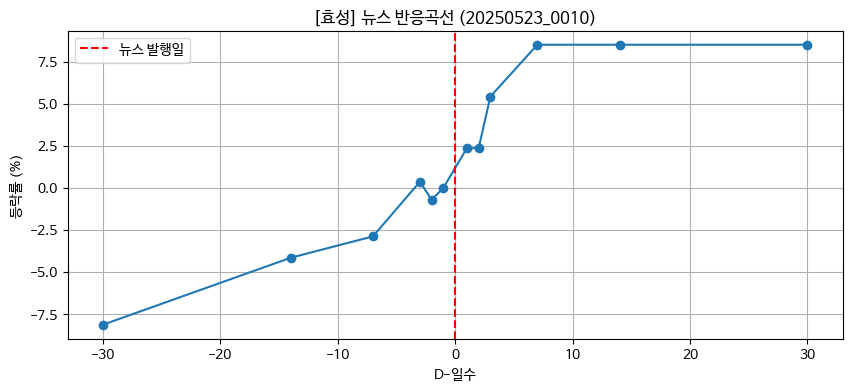

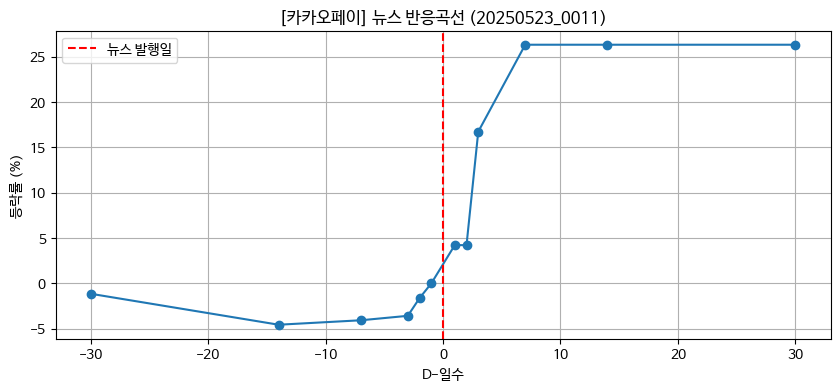

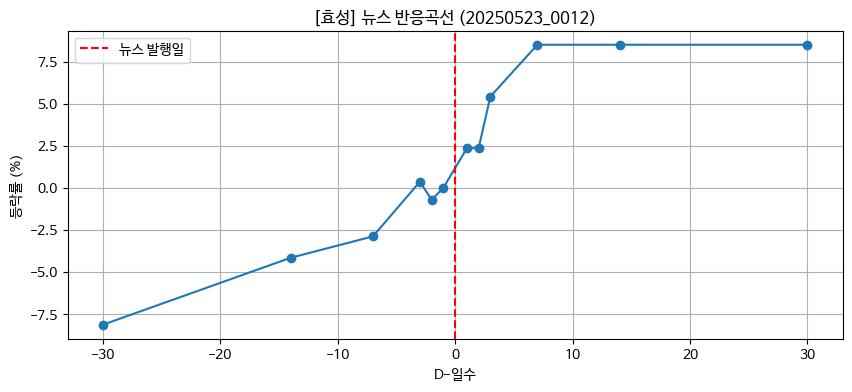

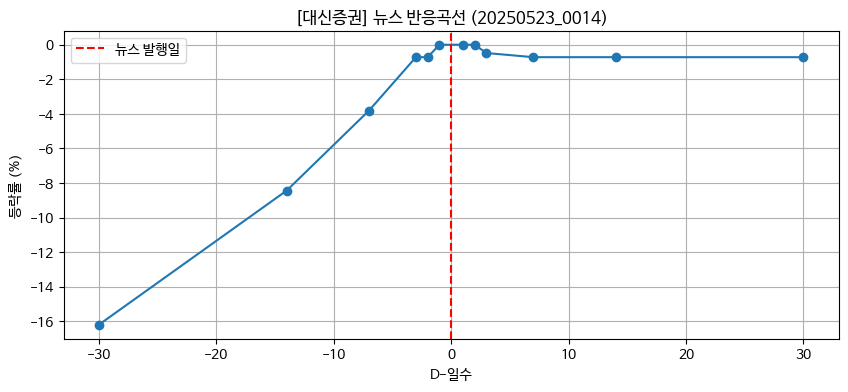

In [78]:
def plot_one_news(row):
    delta_cols = [c for c in row.index if c.startswith("D") and row[c] is not np.nan]
    x = [int(c.replace("D+", "").replace("D-", "-")) for c in delta_cols]
    y = [row[c] for c in delta_cols]

    plt.figure(figsize=(10, 4))
    plt.plot(x, y, marker="o")
    plt.axvline(0, color="red", linestyle="--", label="뉴스 발행일")
    plt.title(f"[{row['stock_name']}] 뉴스 반응곡선 ({row['news_id']})")
    plt.xlabel("D-일수")
    plt.ylabel("등락률 (%)")
    plt.grid(True)
    plt.legend()
    plt.show()


# 사용 예시
for i in range(10):
    plot_one_news(df_combined.iloc[i])

In [79]:
# 등락률 관련 칼럼 추출 (원하면 D+만으로 제한 가능)
delta_cols = ['D-30', 'D-14', 'D-7', 'D-3', 'D-2', 'D-1', 'D+1', 'D+2', 'D+3', 'D+7', 'D+14', 'D+30']

# 최대-최소 진폭 계산
df_combined["impact_score"] = df_combined[delta_cols].max(axis=1) - df_combined[delta_cols].min(axis=1)

In [80]:
df_combined['impact_score'].describe()

count    35198.000000
mean        18.486186
std         13.214733
min          0.000000
25%         10.310000
50%         15.100000
75%         22.970000
max        209.450000
Name: impact_score, dtype: float64

In [81]:
df_combined.to_csv("news_2023_2025_with_stock_impact.csv", index=False)

In [33]:
df_combined_top_20 = df_combined.sort_values(by="impact_score", ascending=False).head(20)
df_combined_top_20

,news_id,wdate,title,press,text_combined,labels_by_id,stock_name,종목코드,base_price,D-30,...,D-3,D-2,D-1,D+1,D+2,D+3,D+7,D+14,D+30,impact_score
32,20241204_0203,2024-12-04 09:11:00,"발빠른 투자자들…이재명 테마주, 줄줄이 상한가 직행",머니투데이,"발빠른 투자자들…이재명 테마주, 줄줄이 상한가 직행 특징주 /사진=임종철 이재명 더...","[이스타코, 일성건설]",이스타코,015020,852.0,-15.14,...,-25.82,-25.82,-23.00,17.49,52.70,52.70,178.76,95.89,152.35,207.87
1370,20241014_0033,2024-10-14 17:32:00,"[속보] MBK·영풍, 고려아연 공개매수로 지분 5% 이상 확보",파이낸셜뉴스,"[속보] MBK·영풍, 고려아연 공개매수로 지분 5% 이상 확보 원본보기 [파이낸셜...","[고려아연, 영풍]",고려아연,010130,817000.0,-18.48,...,-2.82,-2.94,-2.94,-0.98,-2.82,0.86,6.98,88.86,25.46,107.34
1560,20240927_0103,2024-09-27 13:38:00,"영풍 ""MBK와 맞손, 고려아연 살리려는 고육지책…취득 자사주 소각할 것""",한국경제,"영풍 ""MBK와 맞손, 고려아연 살리려는 고육지책…취득 자사주 소각할 것"" 영풍, ...","[고려아연, 영풍, 상상인증권]",고려아연,010130,711000.0,-23.07,...,-0.98,0.28,0.00,-3.23,-3.23,-3.23,9.14,11.67,82.98,106.05
1355,20241204_0041,2024-12-04 17:18:00,"금양, 미국서 811억원 '21700 원통형 이차전지' 발주서 수령",머니투데이,"금양, 미국서 811억원 '21700 원통형 이차전지' 발주서 수령 /사진=금양 홈...",[금양],금양,001570,25650.0,75.44,...,14.62,5.26,0.19,-5.07,-5.07,-12.87,-6.04,3.12,-19.88,95.32
1339,20240312_0091,2024-03-12 13:46:00,"에이프로젠, 허셉틴 시밀러 유럽 EMA 임상3상 시험 승인 ""전세계 시장 공략""",파이낸셜뉴스,"에이프로젠, 허셉틴 시밀러 유럽 EMA 임상3상 시험 승인 ""전세계 시장 공략"" 1...",[에이프로젠],에이프로젠,007460,1082.0,-14.60,...,-16.45,-16.45,-13.22,-4.81,-0.92,-0.92,36.60,39.56,59.98,93.07
1266,20250327_0184,2025-03-27 06:50:00,13년 적자 ‘좀비기업’…주주 돈으로 연명 [기로의상장사]금호전기②,아시아경제,13년 적자 ‘좀비기업’…주주 돈으로 연명 [기로의상장사]금호전기② 결손금만 105...,[금호전기],금호전기,001210,645.0,15.35,...,0.78,-0.16,-1.71,-0.47,-0.47,-1.09,7.29,26.20,86.67,88.38
393,20241031_0246,2024-10-31 09:26:00,외인·기관 쌍끌이 매도…코스피·코스닥 하락 출발,한국경제TV,"외인·기관 쌍끌이 매도…코스피·코스닥 하락 출발 31일 코스피 2,574.55·코스...","[고려아연, LG에너지솔루션, 기아, KB금융, 삼성바이오로직스, 삼성전자, 셀트리온]",고려아연,010130,998000.0,-28.56,...,30.36,54.61,8.32,0.60,0.60,8.72,24.85,2.71,18.24,83.17
1696,20240611_0296,2024-06-11 07:52:00,"""38% 급등에도 PBR 0.37배…한국가스공사 여전히 저평가""-대신",한국경제,"""38% 급등에도 PBR 0.37배…한국가스공사 여전히 저평가""-대신 대신증권 보고...","[한국가스공사, 대신증권]",한국가스공사,036460,44000.0,-40.00,...,-13.18,-6.59,-6.59,4.09,17.73,17.73,26.82,35.00,5.57,75.00
116,20241129_0035,2024-11-29 16:23:00,"나신평, 고려아연 등급전망 하향…""자사주 매입에 재무부담↑""",연합뉴스,"나신평, 고려아연 등급전망 하향…""자사주 매입에 재무부담↑"" 한기평 이어 2번째 신...",[고려아연],고려아연,010130,1180000.0,-15.42,...,-13.64,-3.14,0.00,19.58,19.58,30.68,53.64,3.81,-14.75,73.47
958,20240913_0150,2024-09-13 09:28:00,"""경영권 분쟁 격화"" 고려아연 20% 급등…영풍은 상한가",머니투데이,"""경영권 분쟁 격화"" 고려아연 20% 급등…영풍은 상한가 [특징주] 원본보기 영풍 ...","[영풍, 고려아연]",영풍,000670,37387.0,-19.43,...,-24.87,-23.96,-23.06,0.00,0.00,29.79,47.67,-4.27,11.40,72.54


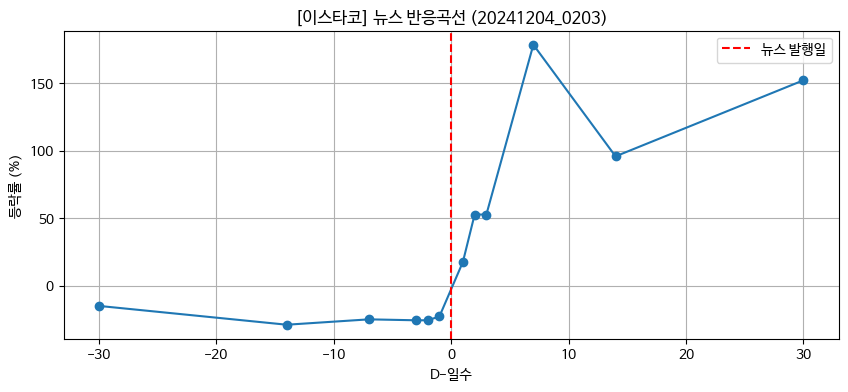

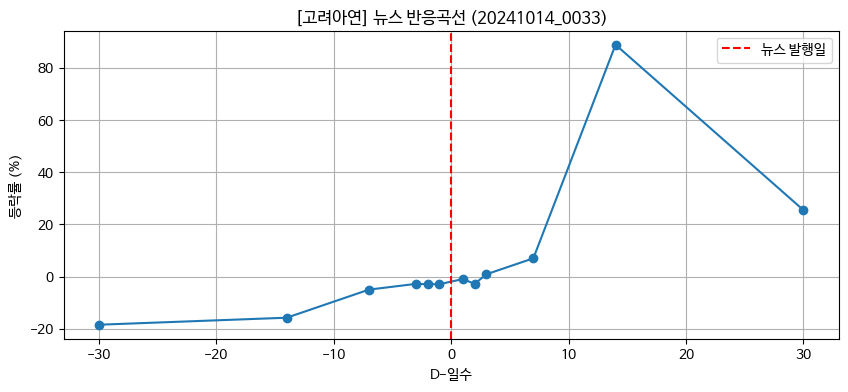

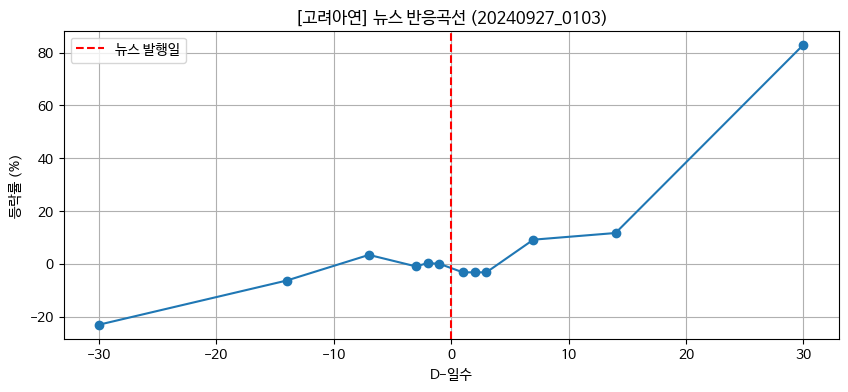

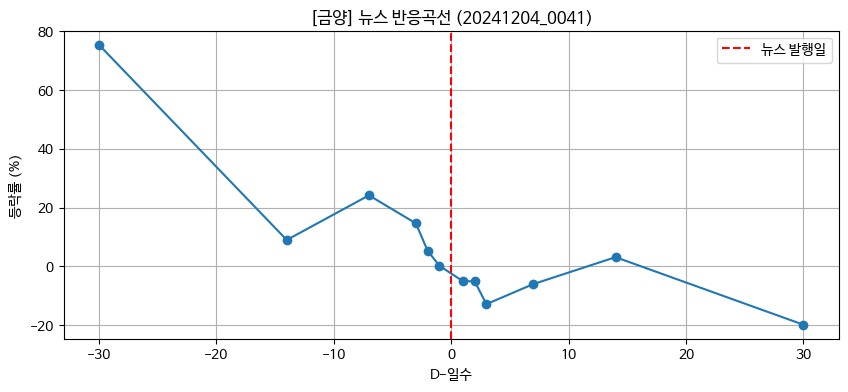

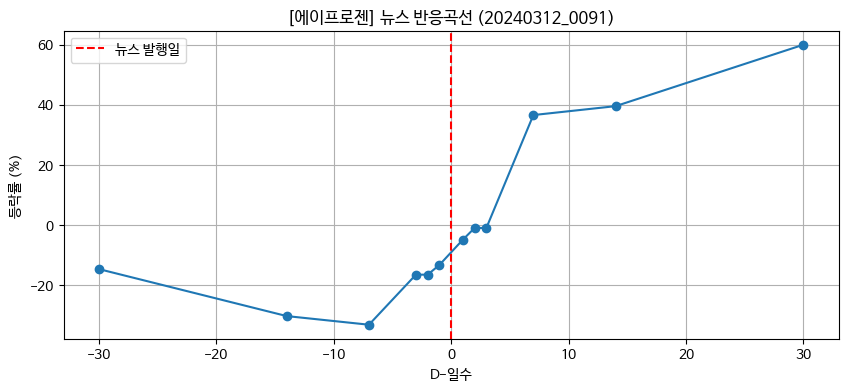

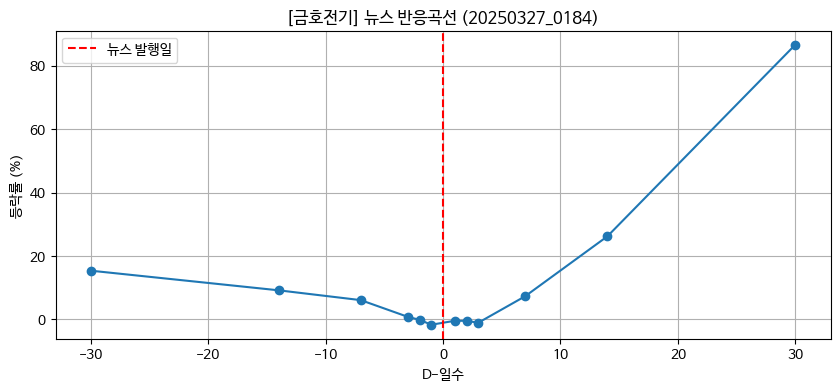

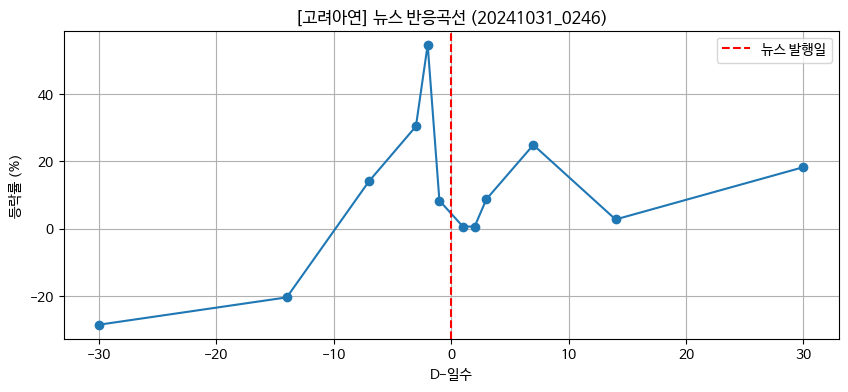

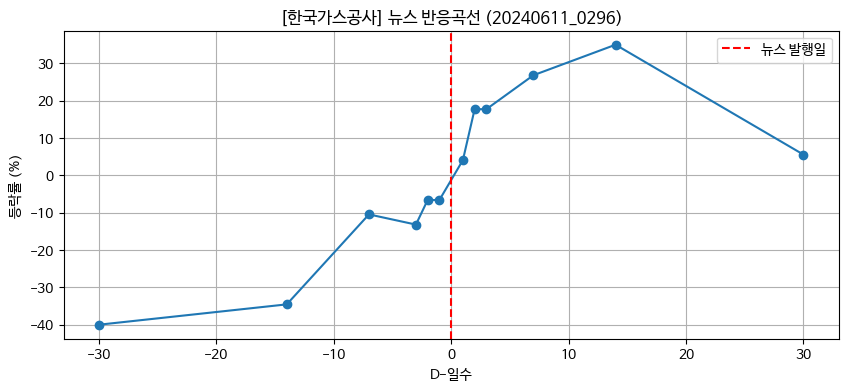

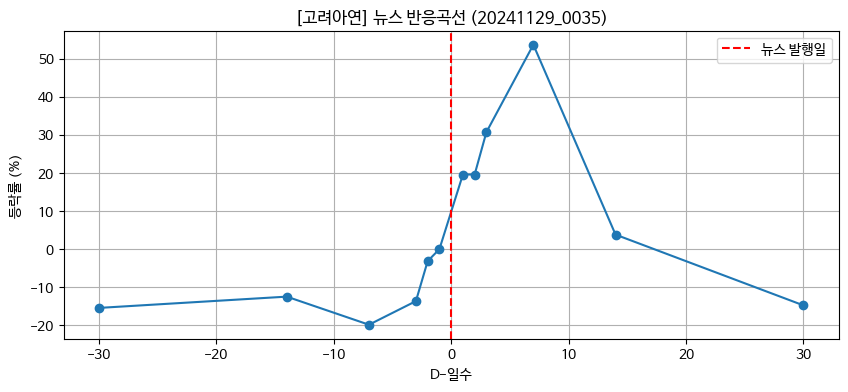

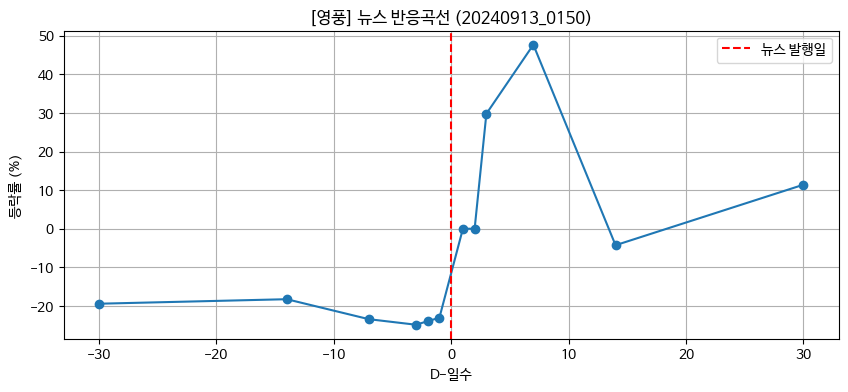

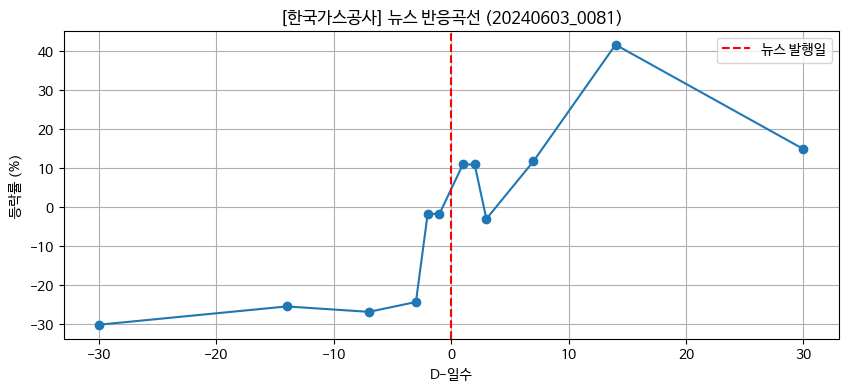

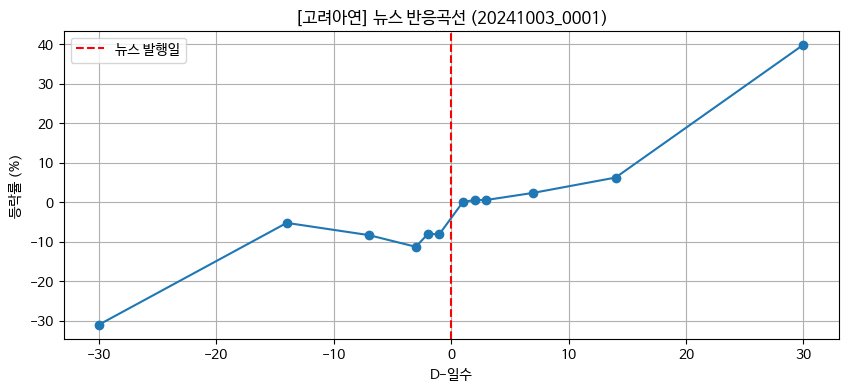

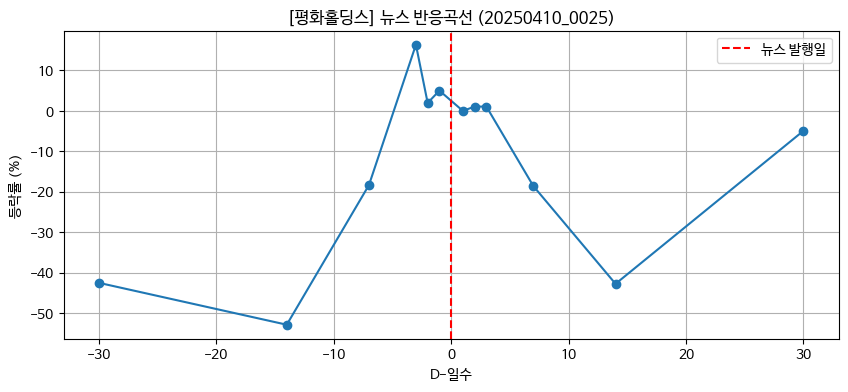

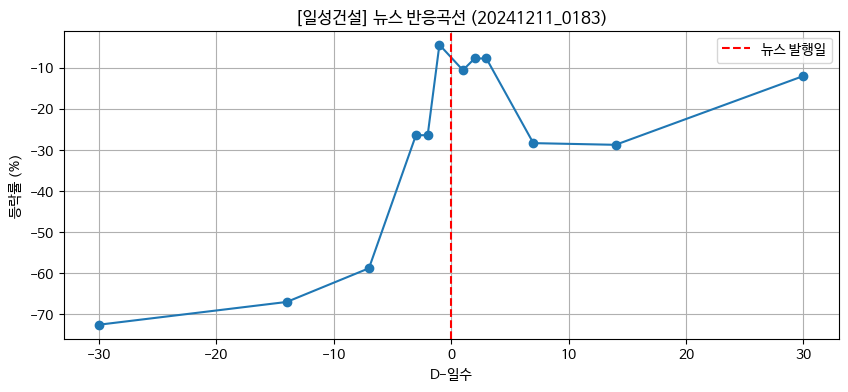

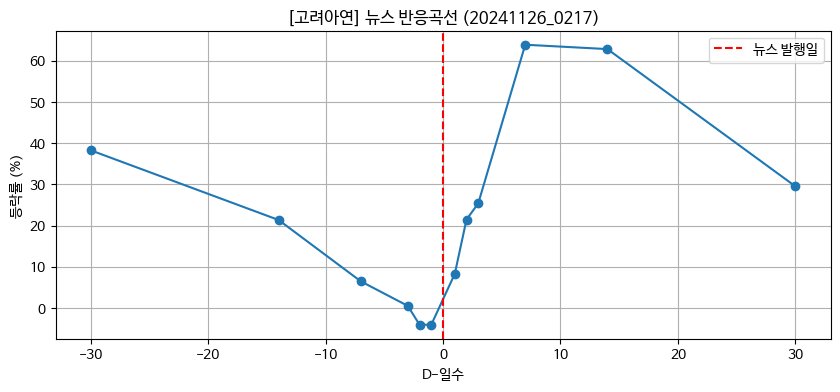

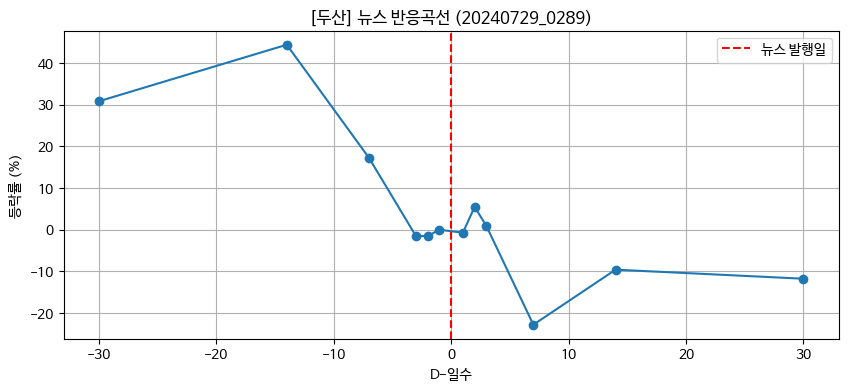

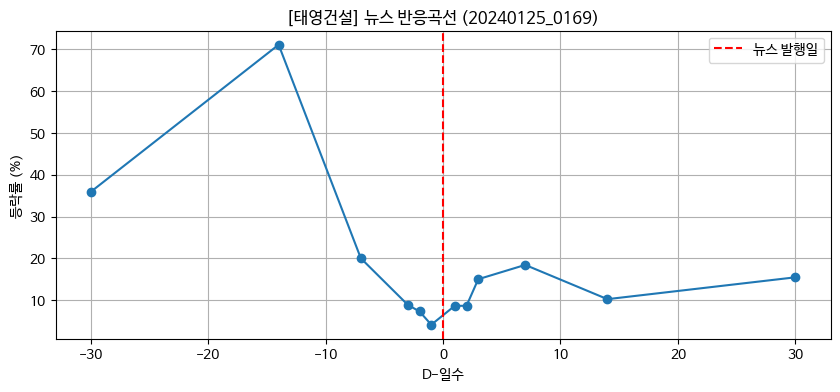

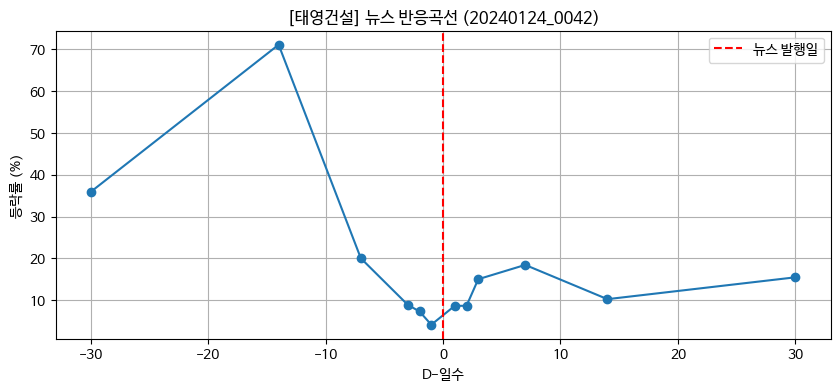

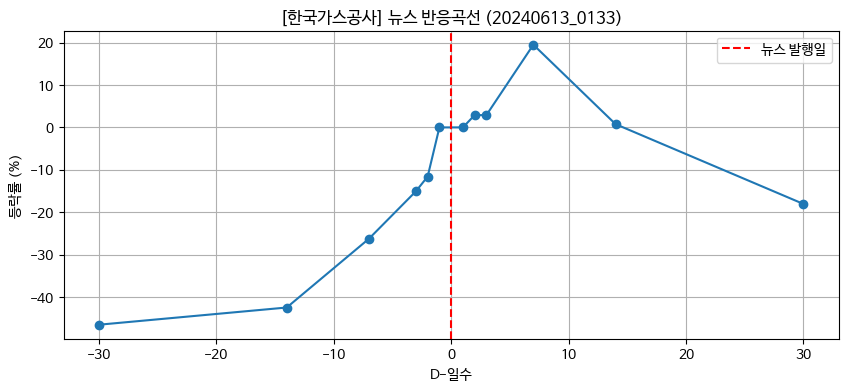

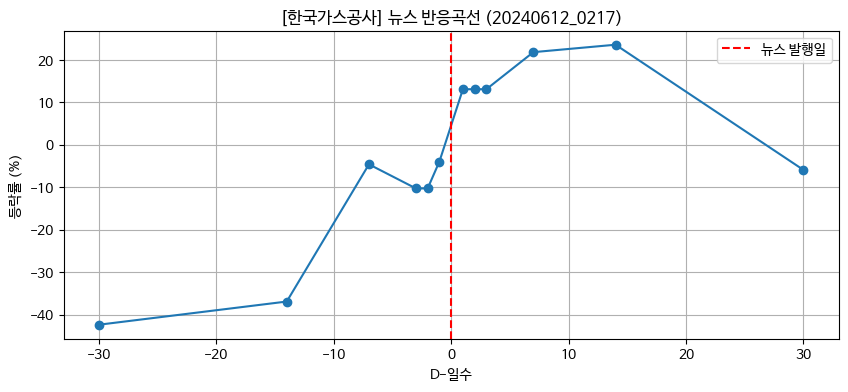

In [43]:
# 사용 예시
for i in range(20):
    plot_one_news(df_combined_top_20.iloc[i])

In [39]:
df_combined_bottom_20 = df_combined.sort_values(by="impact_score", ascending=True)[900:920]
df_combined_bottom_20

,news_id,wdate,title,press,text_combined,labels_by_id,stock_name,종목코드,base_price,D-30,...,D-3,D-2,D-1,D+1,D+2,D+3,D+7,D+14,D+30,impact_score
1144,20250202_0012,2025-02-02 16:38:00,출생아 수 반등에…백화점 유아용품 시장도 성장세,서울경제,출생아 수 반등에…백화점 유아용품 시장도 성장세 출생아 5개월 연속 증가세 신세계百...,[신세계],신세계,004170,129400.0,1.08,...,2.55,2.55,0.00,0.39,0.39,3.71,1.39,7.26,14.91,14.91
520,20241127_0213,2024-11-27 09:06:00,"[클릭 e종목]""두산로보틱스, 그룹 지배구조 개편 최대 수혜""",아시아경제,"[클릭 e종목]""두산로보틱스, 그룹 지배구조 개편 최대 수혜"" DS투자증권은 27일...","[두산밥캣, 두산로보틱스]",두산밥캣,241560,38900.0,-2.70,...,-1.67,-1.67,0.64,-0.13,-0.26,-0.26,8.35,11.05,12.08,14.91
1080,20240130_0206,2024-01-30 09:17:00,"상승기류 올라탄 증시…""대형주, 지수 견인""",한국경제TV,"상승기류 올라탄 증시…""대형주, 지수 견인"" 30일 오전 9시 10분 기준 KOSP...","[LG에너지솔루션, 셀트리온, NAVER, 기아, 삼성바이오로직스, 삼성전자, 현대...",LG에너지솔루션,373220,375000.0,14.53,...,1.60,0.67,0.67,1.60,1.73,3.33,0.53,4.93,7.07,14.93
1148,20250522_0138,2025-05-22 08:28:00,"NH투자 ""'미용기기' 아스테라시스, 신제품 성장 초기 단계""",연합뉴스,"NH투자 ""'미용기기' 아스테라시스, 신제품 성장 초기 단계"" 아스테라시스 [아스테...",[NH투자증권],NH투자증권,005940,15980.0,-12.70,...,-2.50,-0.88,1.13,1.06,1.06,1.69,2.25,2.25,2.25,14.95
1389,20240409_0059,2024-04-09 15:42:00,"금감원, 부동산 PF 리스크 점검 위해 증권사 소집",아시아경제,"금감원, 부동산 PF 리스크 점검 위해 증권사 소집 9일 오전 종투사 9곳 참석해 ...","[NH투자증권, 미래에셋증권]",NH투자증권,005940,11430.0,2.45,...,1.84,1.84,0.00,-1.92,-3.41,-3.41,-3.85,2.54,11.11,14.96
594,20241126_0233,2024-11-26 09:01:00,"NH-Amundi, HANARO 바이오코리아 액티브 ETF 상장",머니투데이,"NH-Amundi, HANARO 바이오코리아 액티브 ETF 상장 NH-Amundi자...","[삼성바이오로직스, 셀트리온]",삼성바이오로직스,207940,929000.0,13.89,...,0.54,3.12,3.12,2.58,7.64,4.95,4.09,3.23,0.86,14.97
1247,20240725_0225,2024-07-25 08:46:00,"'깜짝 실적' LG이노텍…""AI 아이폰 나오는 하반기 기대돼""",한국경제,"'깜짝 실적' LG이노텍…""AI 아이폰 나오는 하반기 기대돼"" 아이폰 16 예상 이...","[키움증권, LG이노텍]",키움증권,039490,126100.0,-0.08,...,7.06,4.60,3.81,0.63,0.63,6.11,7.69,-0.32,8.49,14.99
548,20240301_0001,2024-03-01 21:27:00,"ICTK, 코스닥 상장 예심 승인…상장 절차 본격화",이데일리,"ICTK, 코스닥 상장 예심 승인…상장 절차 본격화 [이데일리 박순엽 기자] ‘차세...","[NH투자증권, 삼성전자, LG유플러스]",NH투자증권,005940,11740.0,-5.20,...,-1.62,0.00,0.00,1.79,1.79,1.28,2.04,9.80,-3.92,15.00
1013,20241121_0308,2024-11-21 07:53:00,"셀트리온, 내년 신규 시밀러 품목 확대…실적 성장 전망-유안타",이데일리,"셀트리온, 내년 신규 시밀러 품목 확대…실적 성장 전망-유안타 [이데일리 이용성 기...","[셀트리온, 유안타증권]",셀트리온,068270,165899.0,7.94,...,-0.63,-0.63,-1.32,-0.12,-0.12,1.78,7.31,4.20,10.82,15.02
30,20240104_0003,2024-01-04 18:47:00,“폐의류로 아동책상 만들어요”…유통·패션 ‘친환경 활동’ 강화,서울경제,"“폐의류로 아동책상 만들어요”…유통·패션 ‘친환경 활동’ 강화 휠라, 맞춤형 가구 ...","[코오롱, BGF리테일, 아모레퍼시픽, CJ제일제당]",코오롱,002020,16760.0,3.10,...,2.03,1.67,0.84,0.00,-0.48,-0.48,0.06,-2.45,12.59,15.04


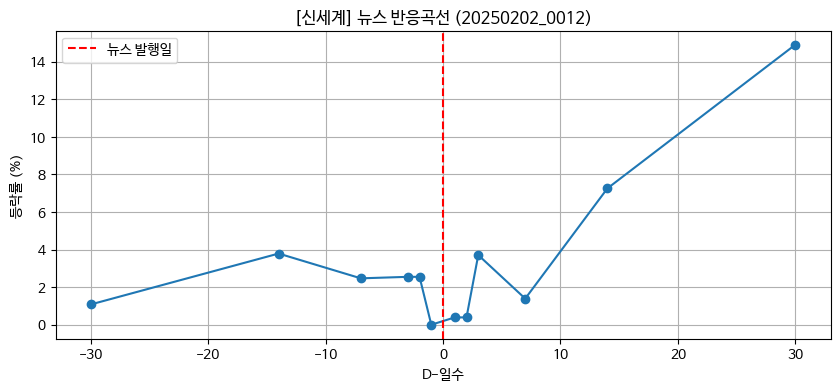

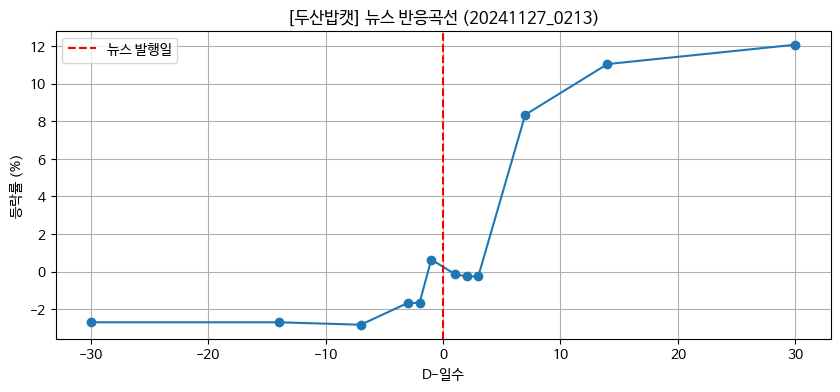

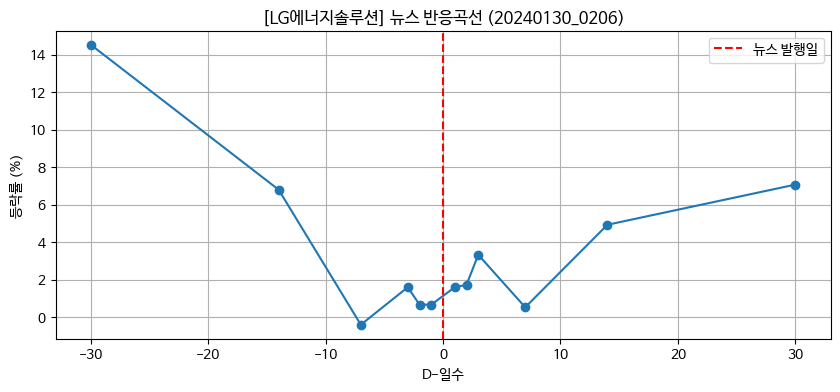

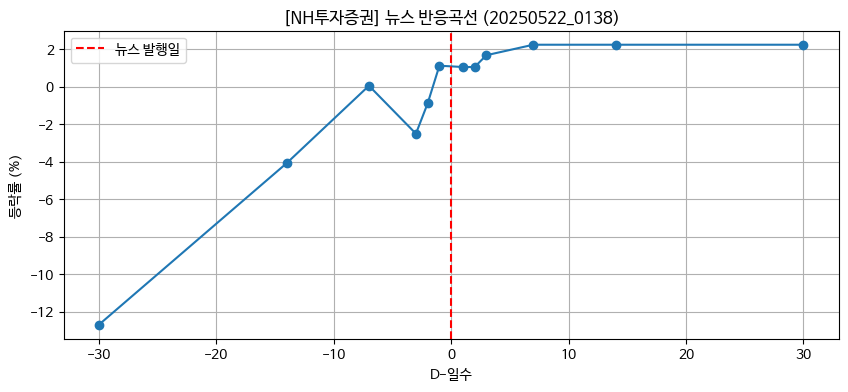

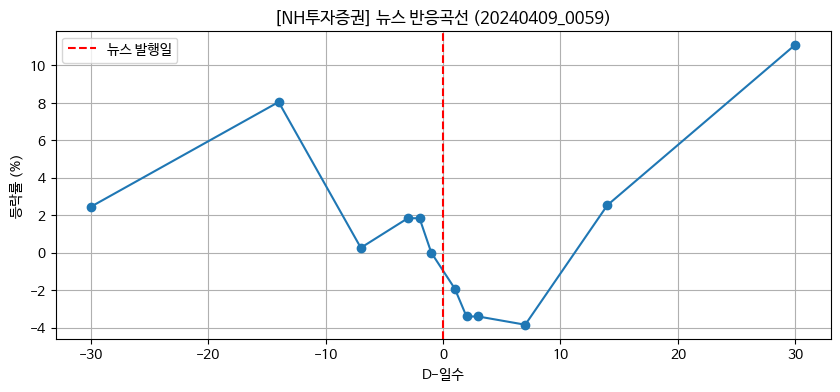

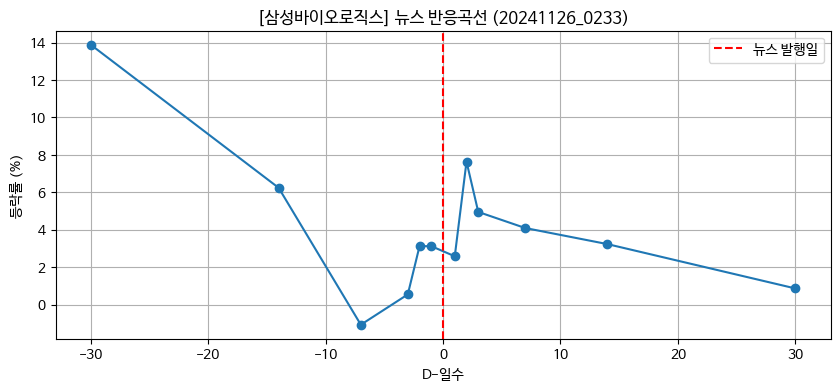

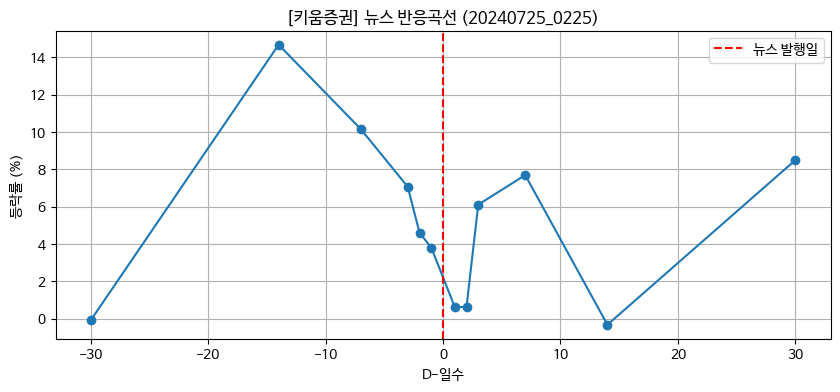

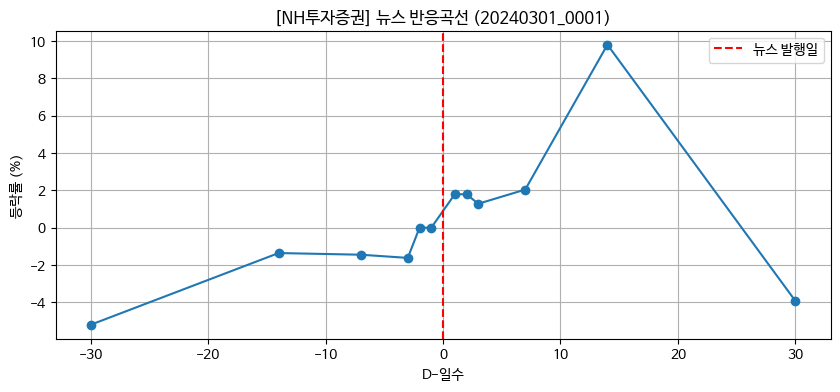

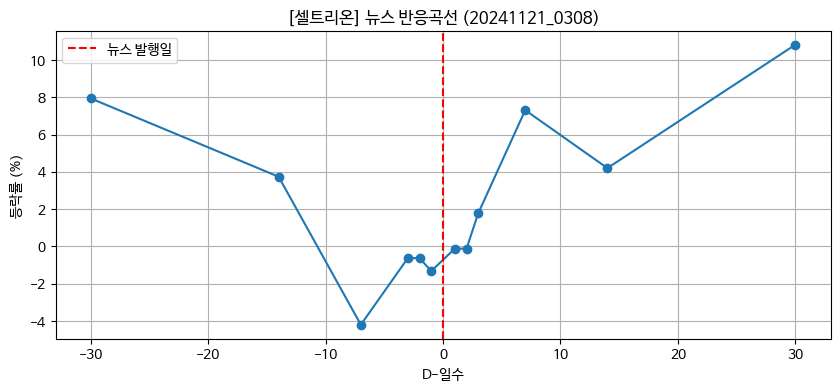

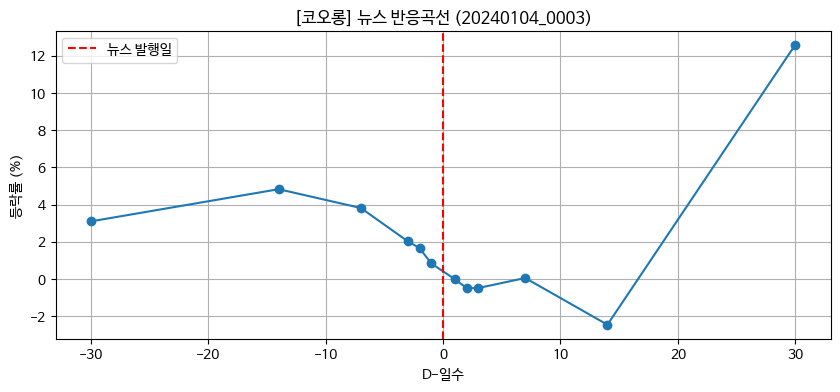

In [40]:
# 사용 예시
for i in range(10):
    plot_one_news(df_combined_bottom_20.iloc[i])

## 데이터셋

In [85]:
df_with_ner = pd.read_csv('news_2023_2025_with_NER.csv')
df_with_ner.head(5)

,news_id,wdate,title,article,press,url,image,text_combined,labels_by_id
0,20250523_0001,2025-05-23 19:11,[마켓인]모태펀드 존속 불확실성 해소될까…이재명 공약에 업계 주목,"2035년 종료 앞둬, 존속 공약에 기대감\n창업 초기자금 공백 완화 가능성에 업계...",이데일리,https://n.news.naver.com/mnews/article/018/000...,https://imgnews.pstatic.net/image/018/2025/05/...,[마켓인]모태펀드 존속 불확실성 해소될까…이재명 공약에 업계 주목 2035년 종료 ...,[]
1,20250523_0002,2025-05-23 18:52,"[단독] 카카오페이, 2500만 회원 쓱·스마일페이 품나…간편결제 시장 빅3 경쟁 후끈",매각가 5000억 안팎 달할듯\n결제시장 내 입지강화 포석\n카카오페이 [사진 = ...,매일경제,https://n.news.naver.com/mnews/article/009/000...,https://imgnews.pstatic.net/image/009/2025/05/...,"[단독] 카카오페이, 2500만 회원 쓱·스마일페이 품나…간편결제 시장 빅3 경쟁 ...",['카카오페이']
2,20250523_0003,2025-05-23 18:38,"키스트론, 일반 청약 흥행…증거금 6조원 모았다","5월22~23일 청약 진행, 경쟁률 총2166대1\n상장 후 예상 시가총개 643억...",머니투데이,https://n.news.naver.com/mnews/article/008/000...,https://imgnews.pstatic.net/image/008/2025/05/...,"키스트론, 일반 청약 흥행…증거금 6조원 모았다 5월22~23일 청약 진행, 경쟁률...",[]
3,20250523_0004,2025-05-23 18:33,"골드만삭스 차기 CEO, 이재용·김병주·이창용 만났다",[사진=연합뉴스]\n세계 2위 투자은행(IB)인 골드만삭스의 사장 겸 최고운영책임자...,매일경제,https://n.news.naver.com/mnews/article/009/000...,https://imgnews.pstatic.net/image/009/2025/05/...,"골드만삭스 차기 CEO, 이재용·김병주·이창용 만났다 [사진=연합뉴스] 세계 2위 ...",['삼성전자']
4,20250523_0005,2025-05-23 18:24,흔들리는 미국…달러 패권 붕괴에 '스테이블코인' 선택한 美,/사진=게티이미지뱅크\n미국 정부가 달러의 기축통화 지위를 위협하는 금에 대응하기 ...,머니투데이,https://n.news.naver.com/mnews/article/008/000...,https://imgnews.pstatic.net/image/008/2025/05/...,흔들리는 미국…달러 패권 붕괴에 '스테이블코인' 선택한 美 /사진=게티이미지뱅크 미...,['상상인증권']


In [87]:
df_with_ner.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58405 entries, 0 to 58404
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   news_id        58405 non-null  object
 1   wdate          58405 non-null  object
 2   title          58405 non-null  object
 3   article        58405 non-null  object
 4   press          58405 non-null  object
 5   url            58405 non-null  object
 6   image          58405 non-null  object
 7   text_combined  58405 non-null  object
 8   labels_by_id   58405 non-null  object
dtypes: object(9)
memory usage: 4.0+ MB


In [95]:
df_with_stock_impact = pd.read_csv('news_2023_2025_with_stock_impact.csv')
df_with_stock_impact.head(5)

,news_id,wdate,title,article,press,url,image,text_combined,labels_by_id,stock_name,...,D-3,D-2,D-1,D+1,D+2,D+3,D+7,D+14,D+30,impact_score
0,20250523_0002,2025-05-23 18:52:00,"[단독] 카카오페이, 2500만 회원 쓱·스마일페이 품나…간편결제 시장 빅3 경쟁 후끈",매각가 5000억 안팎 달할듯\n결제시장 내 입지강화 포석\n카카오페이 [사진 = ...,매일경제,https://n.news.naver.com/mnews/article/009/000...,https://imgnews.pstatic.net/image/009/2025/05/...,"[단독] 카카오페이, 2500만 회원 쓱·스마일페이 품나…간편결제 시장 빅3 경쟁 ...",['카카오페이'],카카오페이,...,-3.57,-1.62,0.0,4.22,4.22,16.72,26.30,26.30,26.30,30.85
1,20250523_0004,2025-05-23 18:33:00,"골드만삭스 차기 CEO, 이재용·김병주·이창용 만났다",[사진=연합뉴스]\n세계 2위 투자은행(IB)인 골드만삭스의 사장 겸 최고운영책임자...,매일경제,https://n.news.naver.com/mnews/article/009/000...,https://imgnews.pstatic.net/image/009/2025/05/...,"골드만삭스 차기 CEO, 이재용·김병주·이창용 만났다 [사진=연합뉴스] 세계 2위 ...",['삼성전자'],삼성전자,...,2.77,0.92,0.0,0.92,0.92,-0.55,3.14,3.14,3.14,5.35
2,20250523_0005,2025-05-23 18:24:00,흔들리는 미국…달러 패권 붕괴에 '스테이블코인' 선택한 美,/사진=게티이미지뱅크\n미국 정부가 달러의 기축통화 지위를 위협하는 금에 대응하기 ...,머니투데이,https://n.news.naver.com/mnews/article/008/000...,https://imgnews.pstatic.net/image/008/2025/05/...,흔들리는 미국…달러 패권 붕괴에 '스테이블코인' 선택한 美 /사진=게티이미지뱅크 미...,['상상인증권'],상상인증권,...,2.47,-2.47,0.0,-1.24,-1.24,-4.12,8.66,8.66,8.66,16.70
3,20250523_0007,2025-05-23 18:00:00,[단독] 전자결제 강자 카카오페이 쓱·스마일 페이 인수 추진,국내 대표 전자결제사업자인 카카오페이가 신세계이마트 산하 간편결제사업부 인수에 나섰...,매일경제,https://n.news.naver.com/mnews/article/009/000...,https://ssl.pstatic.net/static.news/image/news...,[단독] 전자결제 강자 카카오페이 쓱·스마일 페이 인수 추진 국내 대표 전자결제사업...,['카카오페이'],카카오페이,...,-3.57,-1.62,0.0,4.22,4.22,16.72,26.30,26.30,26.30,30.85
4,20250523_0008,2025-05-23 17:58:00,“이 단기 실적 안 좋을 때 사야죠”...비행기 타기 전에 사둔다는 이 주식,큰장 기다리는 韓美 여행주\n시장점유율 1위 부킹홀딩스\n올 최고 유망주 익스피디아...,매일경제,https://n.news.naver.com/mnews/article/009/000...,https://imgnews.pstatic.net/image/009/2025/05/...,“이 단기 실적 안 좋을 때 사야죠”...비행기 타기 전에 사둔다는 이 주식 큰장 ...,"['호텔신라', '하나투어', '아시아나항공', '강원랜드', '대신증권', '대한...",호텔신라,...,-1.35,1.45,0.0,0.52,0.52,1.35,1.14,1.14,1.14,20.72


In [96]:
df_with_stock_impact.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35198 entries, 0 to 35197
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   news_id        35198 non-null  object 
 1   wdate          35198 non-null  object 
 2   title          35198 non-null  object 
 3   article        35198 non-null  object 
 4   press          35198 non-null  object 
 5   url            35198 non-null  object 
 6   image          35198 non-null  object 
 7   text_combined  35198 non-null  object 
 8   labels_by_id   35198 non-null  object 
 9   stock_name     35198 non-null  object 
 10  종목코드           35198 non-null  int64  
 11  상장시가총액         35198 non-null  float64
 12  base_price     35198 non-null  float64
 13  D-30           35198 non-null  float64
 14  D-14           35198 non-null  float64
 15  D-7            35198 non-null  float64
 16  D-3            35198 non-null  float64
 17  D-2            35198 non-null  float64
 18  D-1   

In [92]:
df_with_stock_impact = df_with_stock_impact.dropna(subset=['base_price'])
df_with_stock_impact.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35198 entries, 0 to 35237
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   news_id        35198 non-null  object 
 1   wdate          35198 non-null  object 
 2   title          35198 non-null  object 
 3   article        35198 non-null  object 
 4   press          35198 non-null  object 
 5   url            35198 non-null  object 
 6   image          35198 non-null  object 
 7   text_combined  35198 non-null  object 
 8   labels_by_id   35198 non-null  object 
 9   stock_name     35198 non-null  object 
 10  종목코드           35198 non-null  int64  
 11  상장시가총액         35198 non-null  float64
 12  base_price     35198 non-null  float64
 13  D-30           35198 non-null  float64
 14  D-14           35198 non-null  float64
 15  D-7            35198 non-null  float64
 16  D-3            35198 non-null  float64
 17  D-2            35198 non-null  float64
 18  D-1        

In [94]:
df_with_stock_impact.to_csv("news_2023_2025_with_stock_impact.csv", index=False)

## 학습

In [46]:
from torch.utils.data import Dataset


class NewsImpactDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

In [73]:
from transformers import AutoModel, AutoConfig
import torch.nn as nn


class RobertaRegressionHead(nn.Module):
    def __init__(self, model_name="klue/roberta-base"):
        super().__init__()
        self.config = AutoConfig.from_pretrained(model_name)
        self.backbone = AutoModel.from_pretrained(model_name)
        self.regressor = nn.Sequential(
            nn.Linear(self.config.hidden_size, 128), nn.ReLU(), nn.Linear(128, 1)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0]
        return self.regressor(cls_output).squeeze(-1)

In [74]:
from transformers import AutoTokenizer
import torch

tokenizer = AutoTokenizer.from_pretrained("klue/roberta-base")


def preprocess_data(df):
    df = df[["text_combined", "impact_score"]].dropna()
    df = df[df["text_combined"].str.len() > 10]
    df = df[df["impact_score"] > 0]

    encodings = tokenizer(
        list(df["text_combined"]),
        truncation=True,
        padding="max_length",
        max_length=256,
        return_tensors="pt",
    )

    labels = torch.tensor(df["impact_score"].values, dtype=torch.float)
    return encodings, labels

c:\Users\user\anaconda3\envs\test-0521-1\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\user\.cache\huggingface\hub\models--klue--roberta-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [ ]:
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch

# 데이터 전처리
encodings, labels = preprocess_data(df)  # 이전에 정의한 함수
dataset = NewsImpactDataset(encodings, labels)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# 모델, 옵티마이저
model = RobertaRegressionHead()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.MSELoss()  # 또는 HuberLoss

In [ ]:
train_losses = []

for epoch in range(epochs):
    total_loss = 0
    model.train()
    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}"):
        optimizer.zero_grad()
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]

        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1} Avg Loss: {avg_loss:.4f}")

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, epochs + 1), train_losses, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("학습 손실 (Loss) 추이")
plt.grid(True)
plt.show()

In [ ]:
torch.save(model.state_dict(), "roberta_impact_regression.pt")

## 모델 평가

In [ ]:
model.load_state_dict(torch.load("roberta_impact_regression.pt"))
model.eval()
predict_impact("삼성전자가 실적 발표를 했다", model, tokenizer)

Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


: 

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"]
            attention_mask = batch["attention_mask"]
            labels = batch["labels"]

            preds = model(input_ids, attention_mask)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    mae = mean_absolute_error(all_labels, all_preds)
    rmse = mean_squared_error(all_labels, all_preds, squared=False)
    r2 = r2_score(all_labels, all_preds)

    print(f"✅ MAE:  {mae:.3f}")
    print(f"✅ RMSE: {rmse:.3f}")
    print(f"✅ R²:   {r2:.3f}")

    return all_labels, all_preds